# Introduction

Rain forecasting is very important because heavy and irregular rain can have many impacts like destruction of crops and farms or damage of property. A better forecasting model is essential for an early warning that can minimize risks to life and property and manage the agricultural farms in better way. However, rain prediction is a challenging task and the results should be accurate. By having historical data, machine learning can be used to predict rain accurately for future seasons. Different techniques produce different accuracies, so it's important to choose the right algorithms such as logistic regression and SVM.

Note:
- The data that's used for this analysis is taken from [Kaggle](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package) and has 145,460 rows and 23 columns.
- The models have been deployed using Streamlit and can be found [here](https://darren7753-h8-3-pytn-kampusmerdeka-fp2-athifah-darrenapp-gikdg3.streamlit.app/).

# Import Libraries

In [1]:
# Data Wrangling
import numpy as np
import sympy as sp
import pandas as pd
from dython.nominal import associations

# Data Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,classification_report,confusion_matrix,ConfusionMatrixDisplay
from pickle import dump,load

# Settings
pd.set_option("display.max.columns",None)
%matplotlib inline
mpl.style.use(["ggplot"])

# Data Loading

Import *weatherAUS.csv* as *df*.

In [2]:
df = pd.read_csv("weatherAUS.csv")
df.columns = df.columns.str.lower()
df.head()

,date,location,mintemp,maxtemp,rainfall,evaporation,sunshine,windgustdir,windgustspeed,winddir9am,winddir3pm,windspeed9am,windspeed3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,cloud9am,cloud3pm,temp9am,temp3pm,raintoday,raintomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


Check the shape of the dataset which has 145,460 rows and 23 columns.

In [3]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 145460
Number of Columns	: 23


# Data Cleaning

Retrieve information about the dataset, including *NaN* values.

In [4]:
pd.DataFrame({
    "type":df.dtypes.values,
    "null":df.isnull().sum().values,
    "null_percentage":df.isnull().sum().values / len(df) * 100,
    "unique":[df[i].nunique() for i in df.columns],
    "sample":[list(pd.Series(df.dropna()[i].unique()).sample())[0] for i in df.columns]
}).set_index(df.isnull().sum().index).sort_values("null",ascending=False)

,type,null,null_percentage,unique,sample
sunshine,float64,69835,48.009762,145,7.0
evaporation,float64,62790,43.166506,358,34.4
cloud3pm,float64,59358,40.807095,10,9.0
cloud9am,float64,55888,38.421559,10,3.0
pressure9am,float64,15065,10.356799,546,1006.5
pressure3pm,float64,15028,10.331363,549,1016.7
winddir9am,object,10566,7.263853,16,S
windgustdir,object,10326,7.098859,16,N
windgustspeed,float64,10263,7.055548,67,56.0
humidity3pm,float64,4507,3.098446,101,93.0


As it can be seen, *sunshine*, *evaporation*, *cloud3pm*, and *cloud9am* features have lots of *NaN* values. Replacing those might increase the inaccuracy of the dataset. Thus, those features can be dropped instead. Furthermore, *date* feature can be dropped as well because this isn't a time series analysis.

In [5]:
df = df.drop(["date"] + list(df.isnull().sum().sort_values(ascending=False).iloc[:4].index),axis=1)

Specify which features are categorical and numerical.

In [6]:
cat_cols = df.columns[df.dtypes == object]
num_cols = df.columns[df.dtypes != object]

print(f"Categorical Columns\t({len(cat_cols)})\t: {list(cat_cols)}")
print(f"Numerical Columns\t({len(num_cols)})\t: {list(num_cols)}")

Categorical Columns	(6)	: ['location', 'windgustdir', 'winddir9am', 'winddir3pm', 'raintoday', 'raintomorrow']
Numerical Columns	(12)	: ['mintemp', 'maxtemp', 'rainfall', 'windgustspeed', 'windspeed9am', 'windspeed3pm', 'humidity9am', 'humidity3pm', 'pressure9am', 'pressure3pm', 'temp9am', 'temp3pm']


Replace *NaN* values in categorical and numerical features with their modes and means respectively.

In [7]:
print("Categorical Columns")
for i in cat_cols:
    df[i] = df[i].fillna(df[i].mode().values[0])
    print(f"NaN values in {i} have been replaced by {df[i].mode().values[0]}")

print("\nNumerical Columns")
for i in num_cols:
    df[i] = df[i].fillna(df[i].mean())
    print(f"NaN values in {i} have been replaced by {df[i].mean()}")

Categorical Columns
NaN values in location have been replaced by Canberra
NaN values in windgustdir have been replaced by W
NaN values in winddir9am have been replaced by N
NaN values in winddir3pm have been replaced by SE
NaN values in raintoday have been replaced by No
NaN values in raintomorrow have been replaced by No

Numerical Columns
NaN values in mintemp have been replaced by 12.194034380968839
NaN values in maxtemp have been replaced by 23.22134827564668
NaN values in rainfall have been replaced by 2.3609181499170364
NaN values in windgustspeed have been replaced by 40.035230071663854
NaN values in windspeed9am have been replaced by 14.043425914971664
NaN values in windspeed3pm have been replaced by 18.66265677888777
NaN values in humidity9am have been replaced by 68.88083133761891
NaN values in humidity3pm have been replaced by 51.5391158755115
NaN values in pressure9am have been replaced by 1017.6499397985187
NaN values in pressure3pm have been replaced by 1015.2558888310605

Create a function to detect and visualize outliers.

In [8]:
def create_boxplot(num1,num2,data,x_axis):
    nrows,ncols = num1,num2

    fig,ax=plt.subplots(nrows,ncols,figsize=(25,15),dpi=200)

    n = 0
    for i in range(nrows):
        for j in range(ncols):
            sns.boxplot(data=data,x=x_axis[n],ax=ax[i,j])
            ax[i,j].set_title(f"Box Plot of {x_axis[n]}")
            n += 1

    plt.tight_layout()
    plt.show()

def find_outlier(data):
    q1 = np.quantile(data,0.25)
    q3 = np.quantile(data,0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)
    
    outlier = []
    for i in data:
        if (i < min_iqr) or (i > max_iqr):
            outlier.append(i)
    
    return outlier

Detect and visualize outliers for each numerical feature using box plot. As it can be seen, there are lots of outliers.

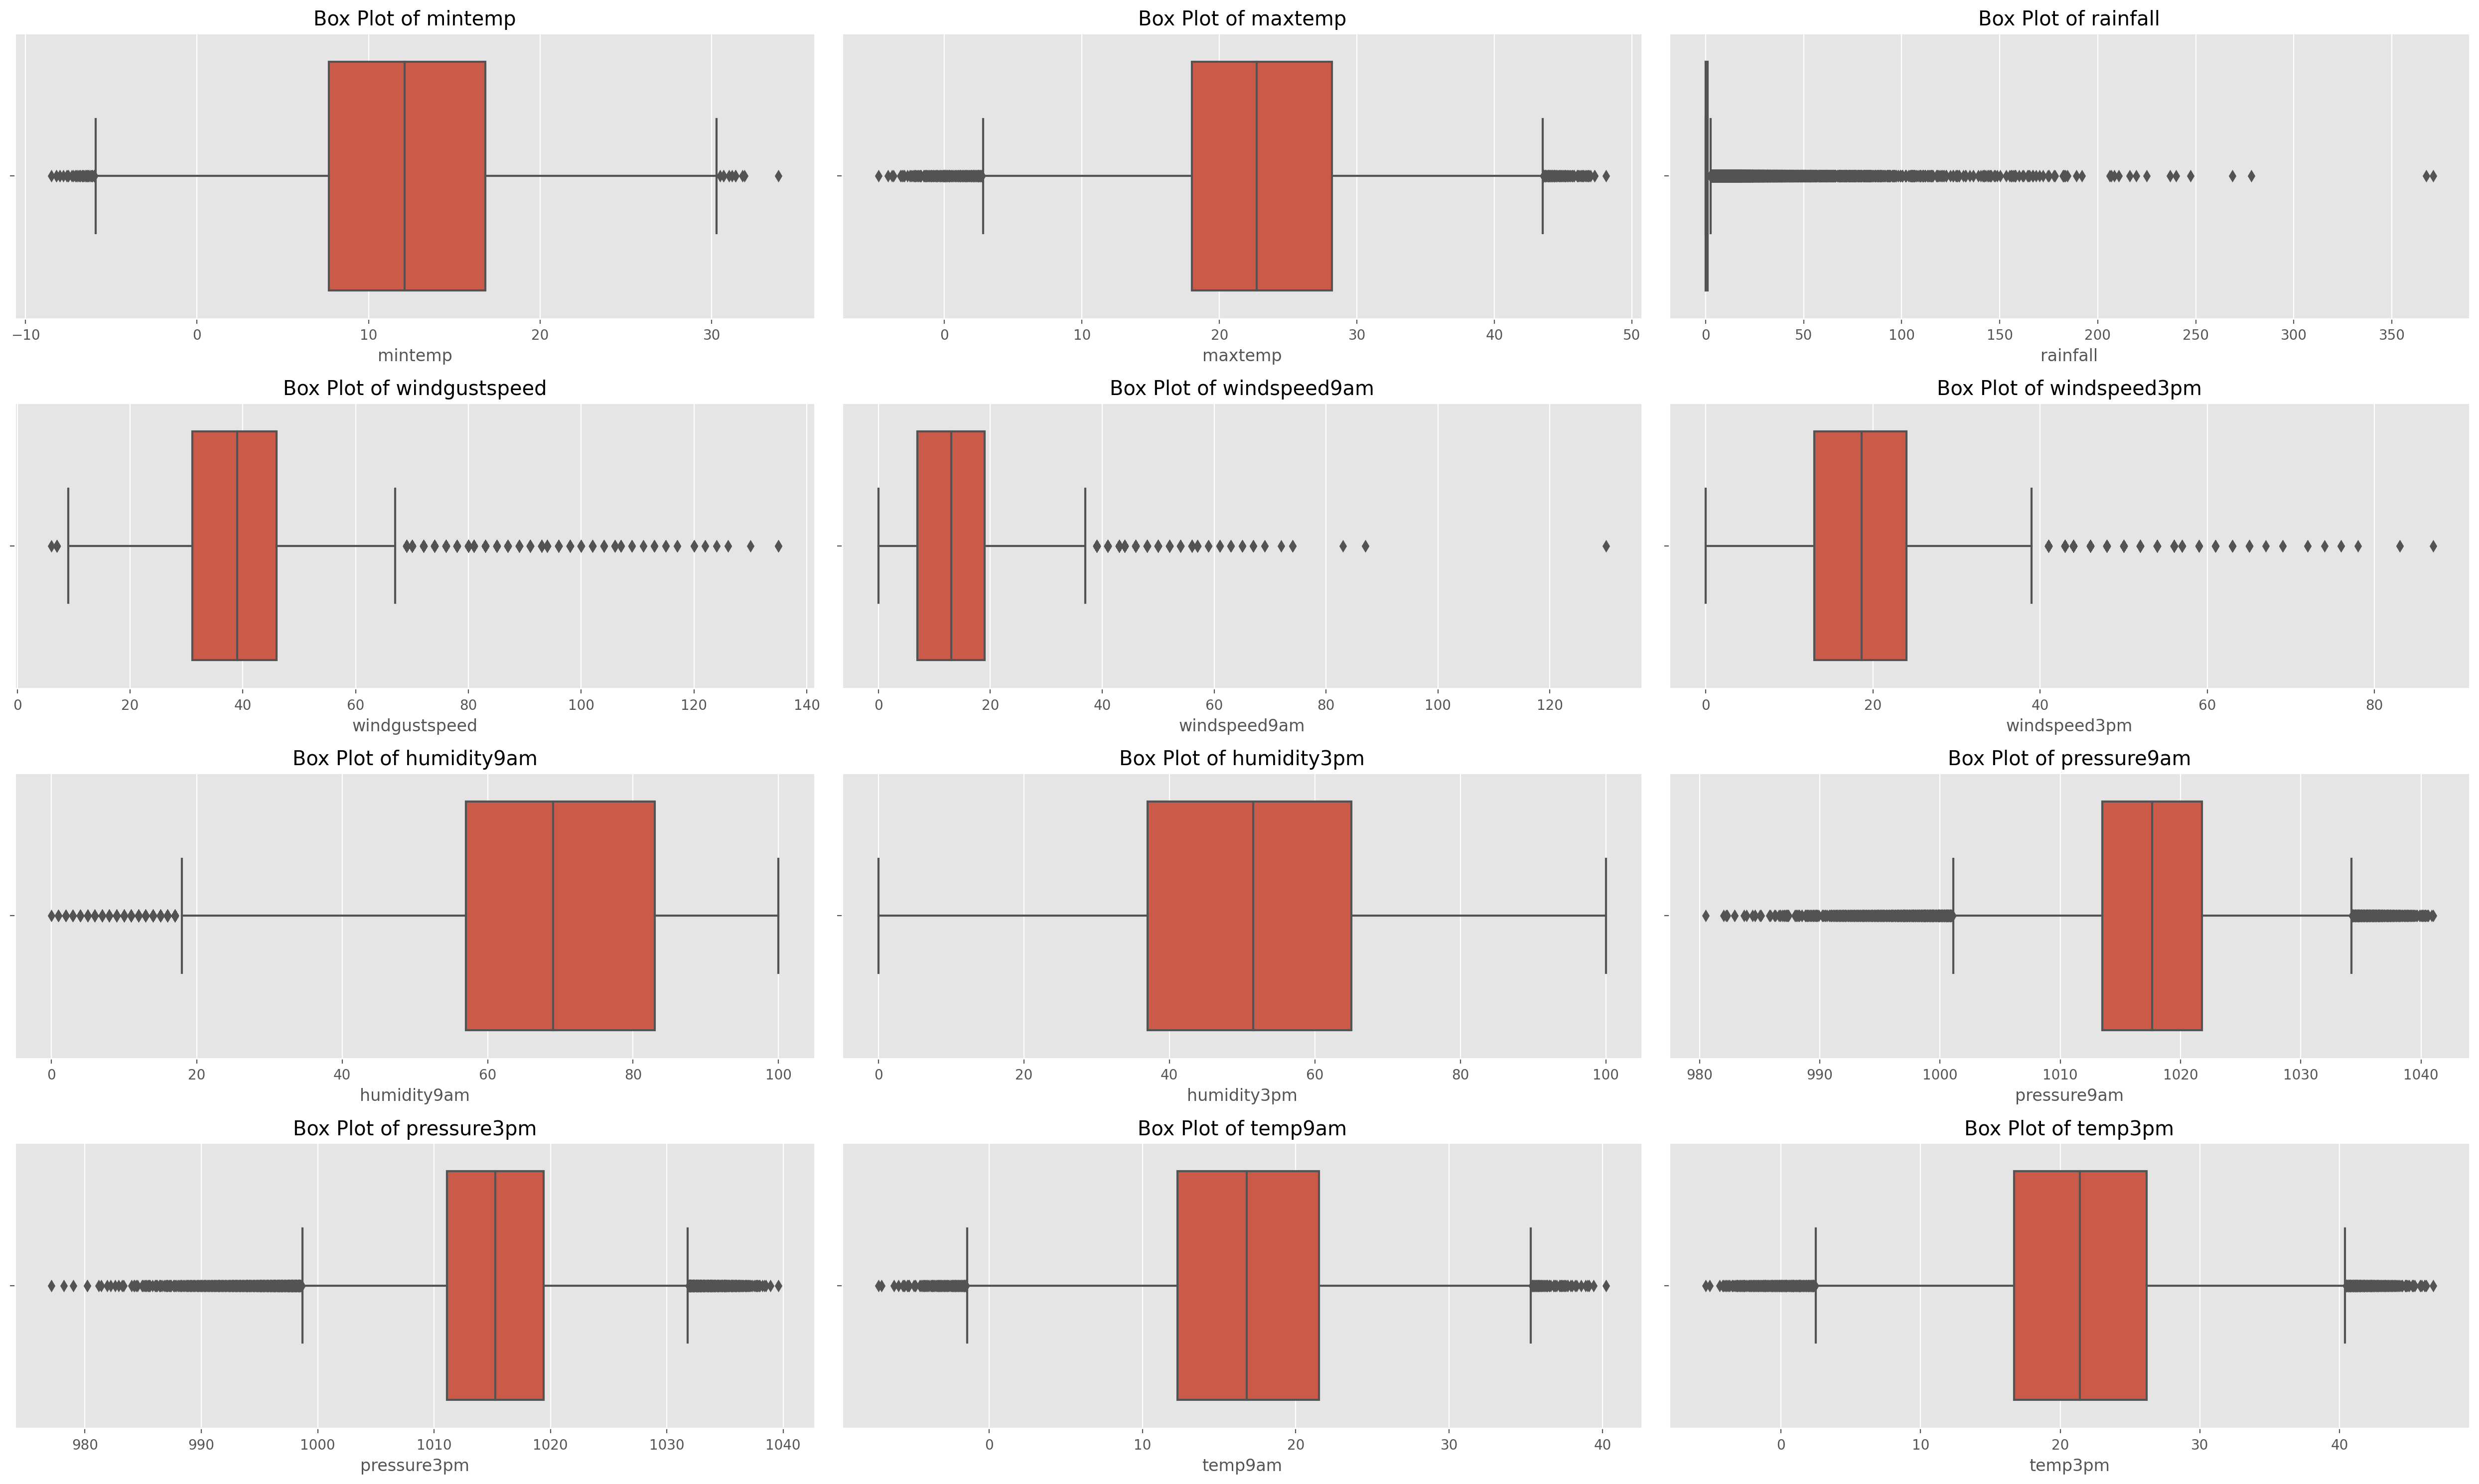

,outliers,percentage
rainfall,23723,16.308951
windgustspeed,5523,3.796920
pressure9am,2758,1.896054
pressure3pm,2524,1.735185
windspeed3pm,2523,1.734497
windspeed9am,1817,1.249141
humidity9am,1425,0.979651
temp3pm,988,0.679225
maxtemp,544,0.373986
temp9am,307,0.211055


In [9]:
create_boxplot(4,3,df,num_cols)

pd.DataFrame({
    "outliers":[len(j) for j in [find_outlier(df[i]) for i in num_cols]],
    "percentage":np.array([len(j) for j in [find_outlier(df[i]) for i in num_cols]]) / len(df) * 100
}).set_index(num_cols).sort_values("outliers",ascending=False)

Remove outliers by only taking the values that are within the upper and lower limits.

In [10]:
for i in num_cols:
    q1 = np.quantile(df[i],0.25)
    q3 = np.quantile(df[i],0.75)
    
    iqr = q3 - q1
    min_iqr = q1 - (1.5 * iqr)
    max_iqr = q3 + (1.5 * iqr)

    df = df[(df[i] >= min_iqr) & (df[i] <= max_iqr)]

Detect and visualize outliers for the 2nd time. As it can be seen, although *rainfall* feature still has a few outliers, overall it's much better than it was. Also, remove outliers in *rainfall* feature will reduce the size of the dataset significantly, so we'll leave as it is now.

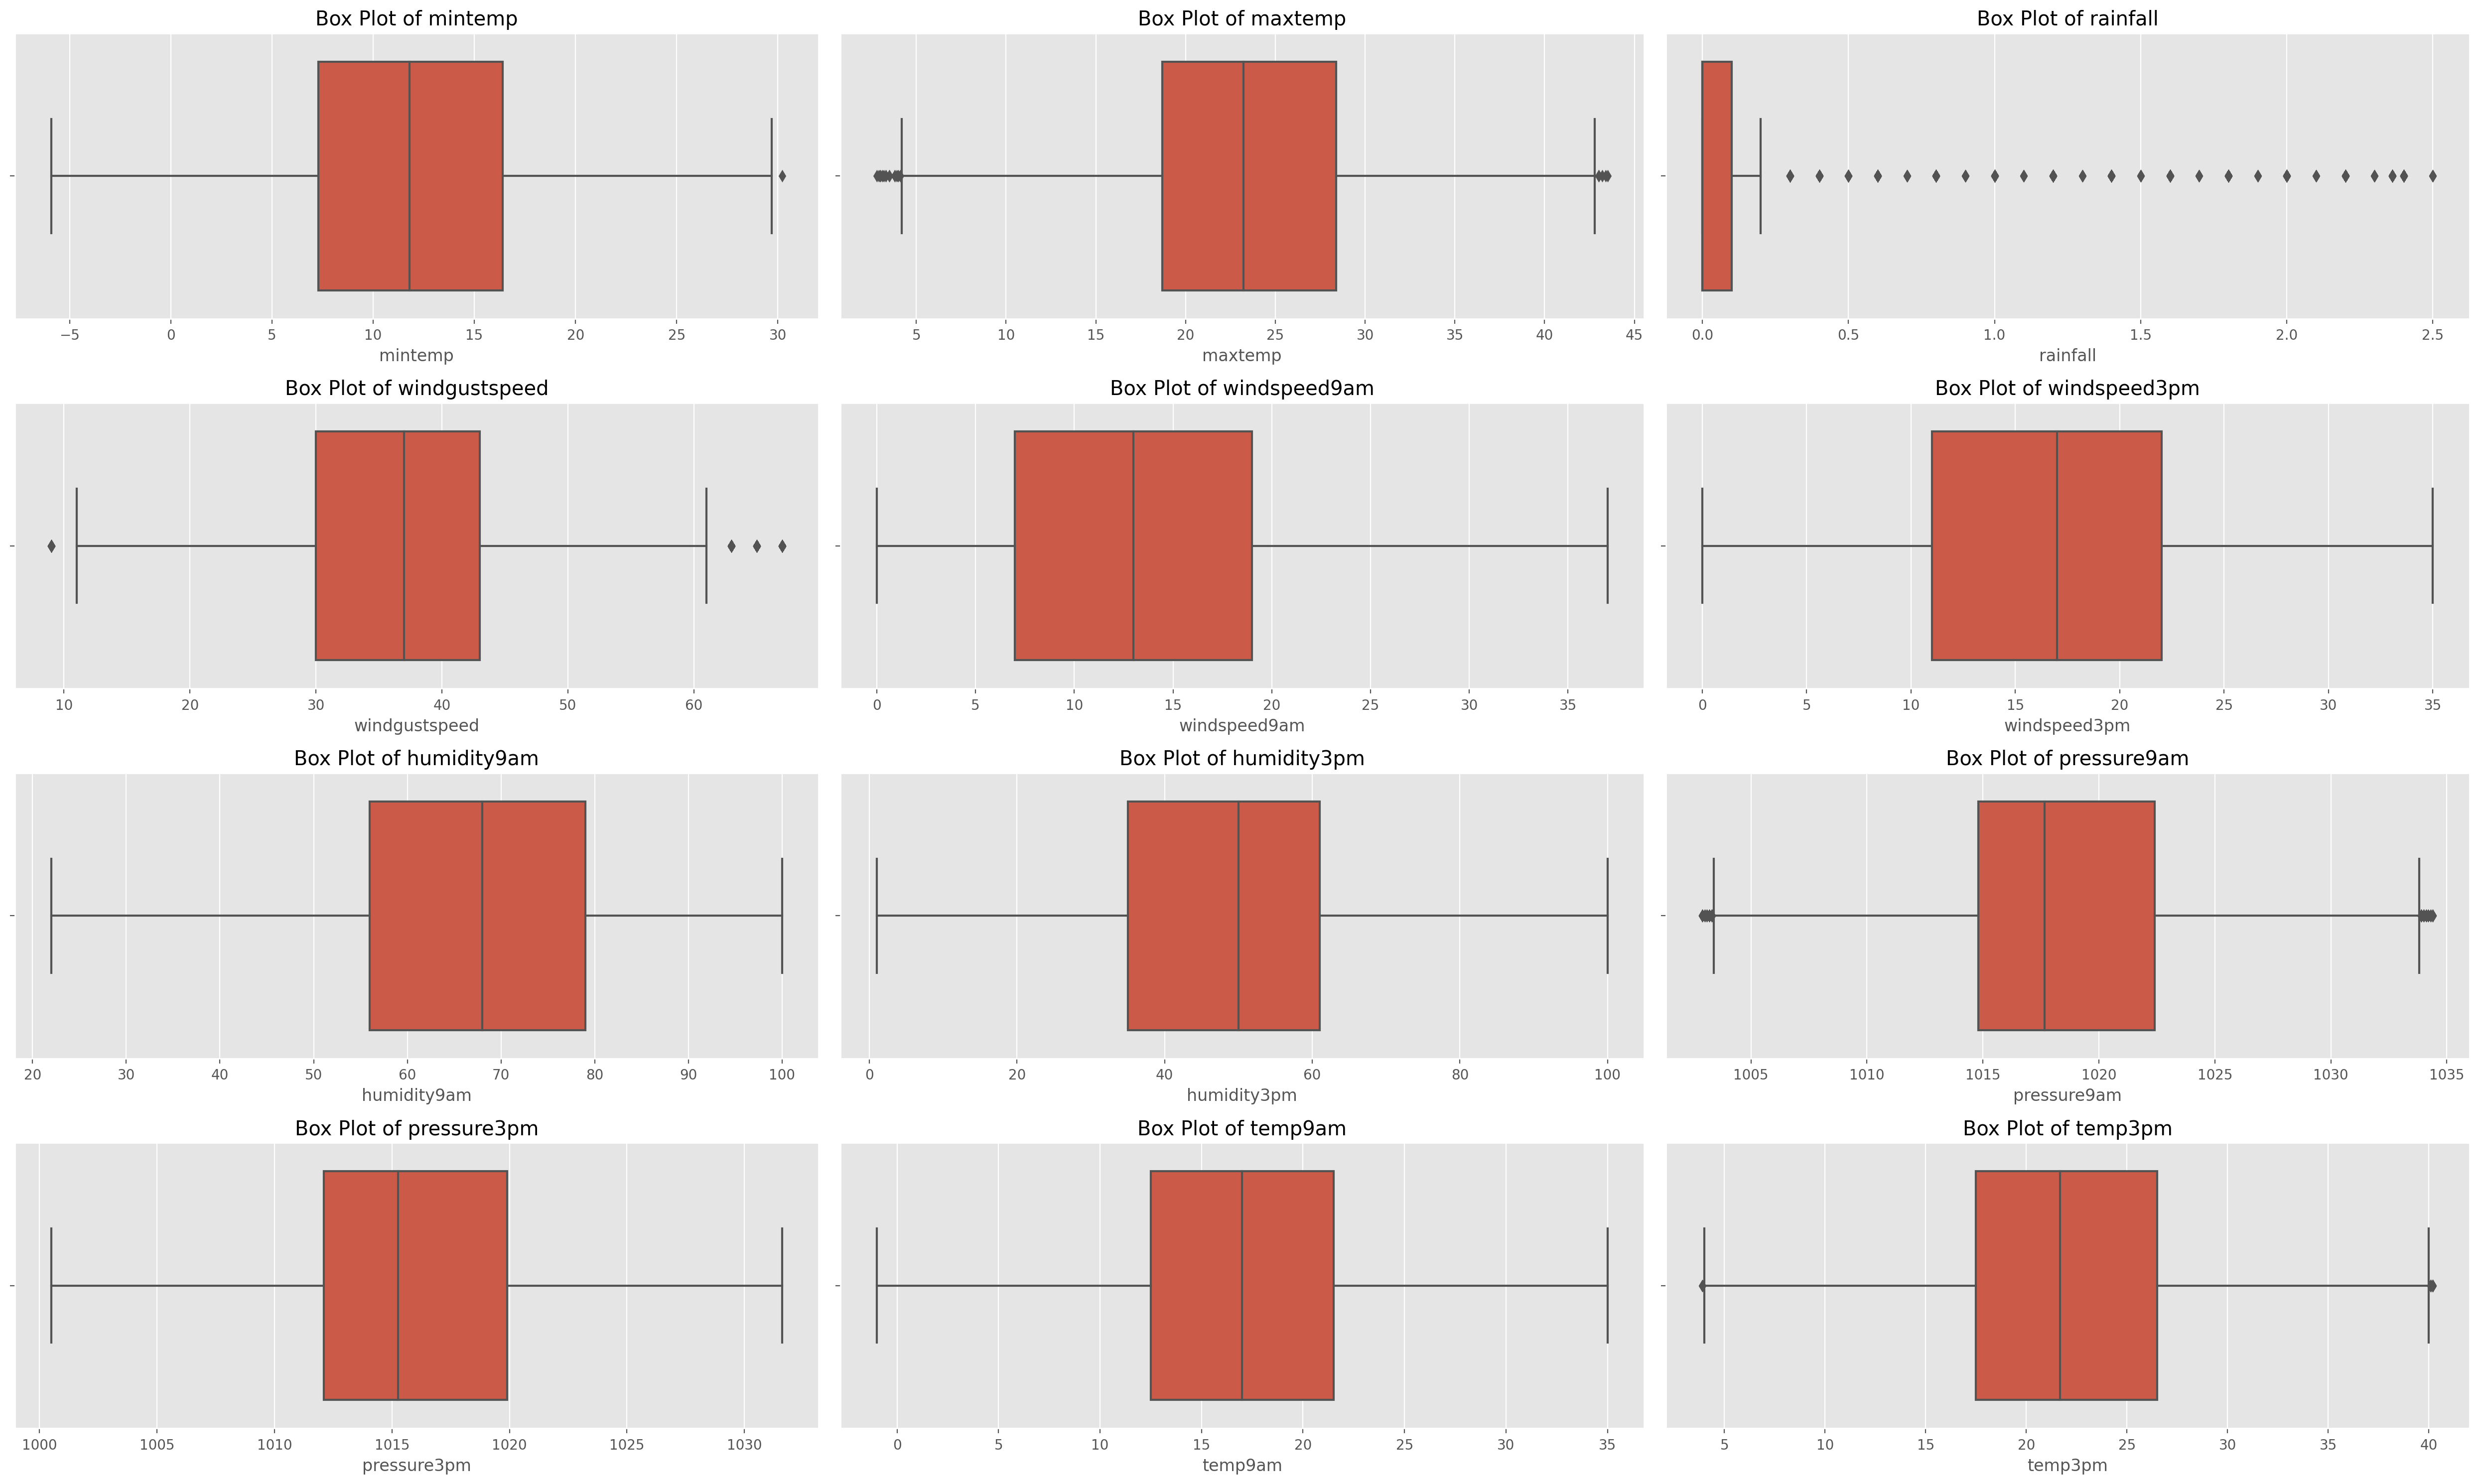

,outliers,percentage
rainfall,19371,17.598321
windgustspeed,1531,1.390895
pressure9am,283,0.257102
temp3pm,33,0.029980
maxtemp,20,0.018170
mintemp,1,0.000908
windspeed9am,0,0.000000
windspeed3pm,0,0.000000
humidity9am,0,0.000000
humidity3pm,0,0.000000


In [11]:
create_boxplot(4,3,df,num_cols)

pd.DataFrame({
    "outliers":[len(j) for j in [find_outlier(df[i]) for i in num_cols]],
    "percentage":np.array([len(j) for j in [find_outlier(df[i]) for i in num_cols]]) / len(df) * 100
}).set_index(num_cols).sort_values("outliers",ascending=False)

Find the correlation between numerical and categorical features with the help of *dython* library.

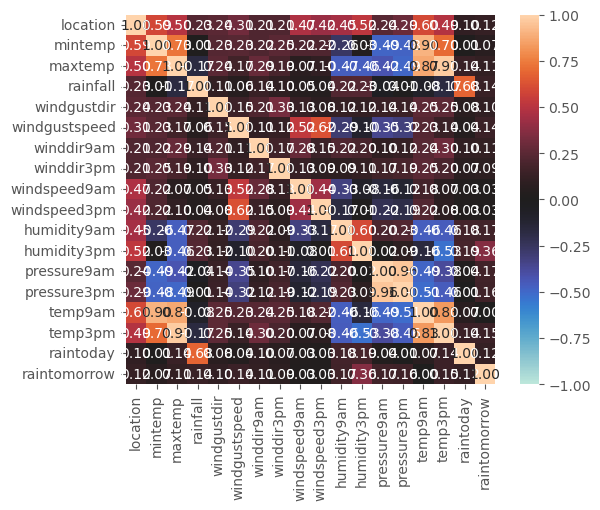

In [12]:
corr = associations(df)

Since we want to know which features that influence *raintomorrow* the most, we'll sort the correlation coefficients in descending order.

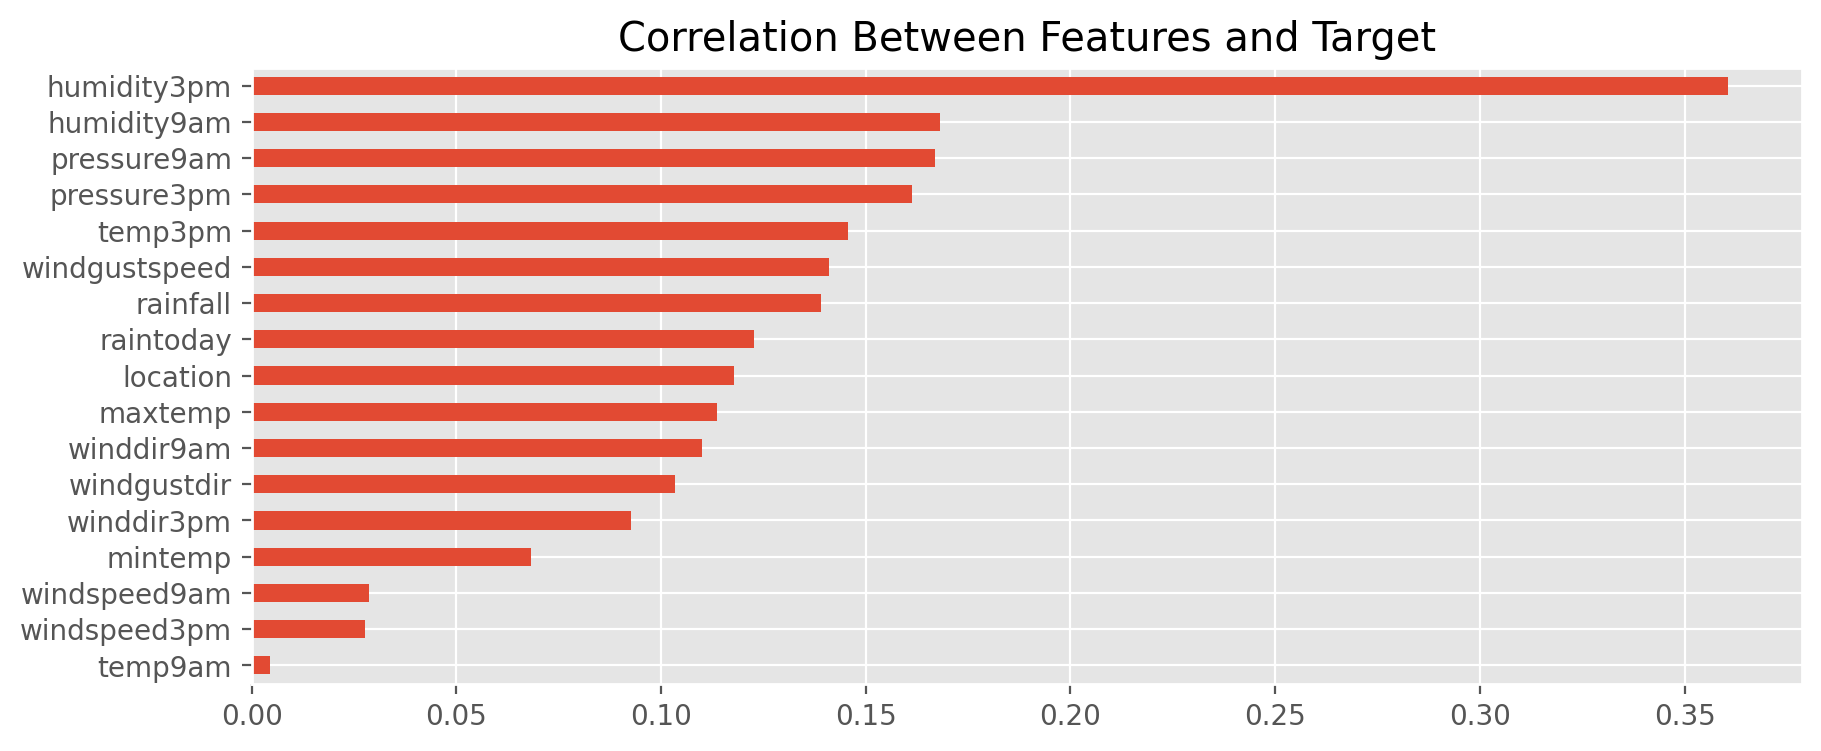

In [13]:
fig = plt.figure(figsize=(10,4),dpi=200)
corr["corr"][["raintomorrow"]].iloc[:-1].sort_values("raintomorrow").plot(
    kind="barh",
    legend=None,
    title="Correlation Between Features and Target",
    ax=plt.gca()
)
plt.show()

As it can be seen from the plot above, *windspeed9am*, *windspeed3pm*, and *temp9am* features have the least influence on *raintomorrow* and thus those features can be dropped.

In [14]:
df = df.drop(corr["corr"][["raintomorrow"]].sort_values("raintomorrow").iloc[:3].index,axis=1)
df.head()

,location,mintemp,maxtemp,rainfall,windgustdir,windgustspeed,winddir9am,winddir3pm,humidity9am,humidity3pm,pressure9am,pressure3pm,temp3pm,raintoday,raintomorrow
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,71.0,22.0,1007.7,1007.1,21.8,No,No
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,44.0,25.0,1010.6,1007.8,24.3,No,No
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,38.0,30.0,1007.6,1008.7,23.2,No,No
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,45.0,16.0,1017.6,1012.8,26.5,No,No
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,82.0,33.0,1010.8,1006.0,29.7,No,No


The cleaned dataset now has 110,073 rows and 15 columns.

In [15]:
print(f"Number of Rows\t\t: {df.shape[0]}")
print(f"Number of Columns\t: {df.shape[1]}")

Number of Rows		: 110073
Number of Columns	: 15


# Data Exploration

See how often it rains by visualizing both *raintoday* and *raintomorrow*. As it can be seen, the dataset isn't evenly distributed within these 2 classes.

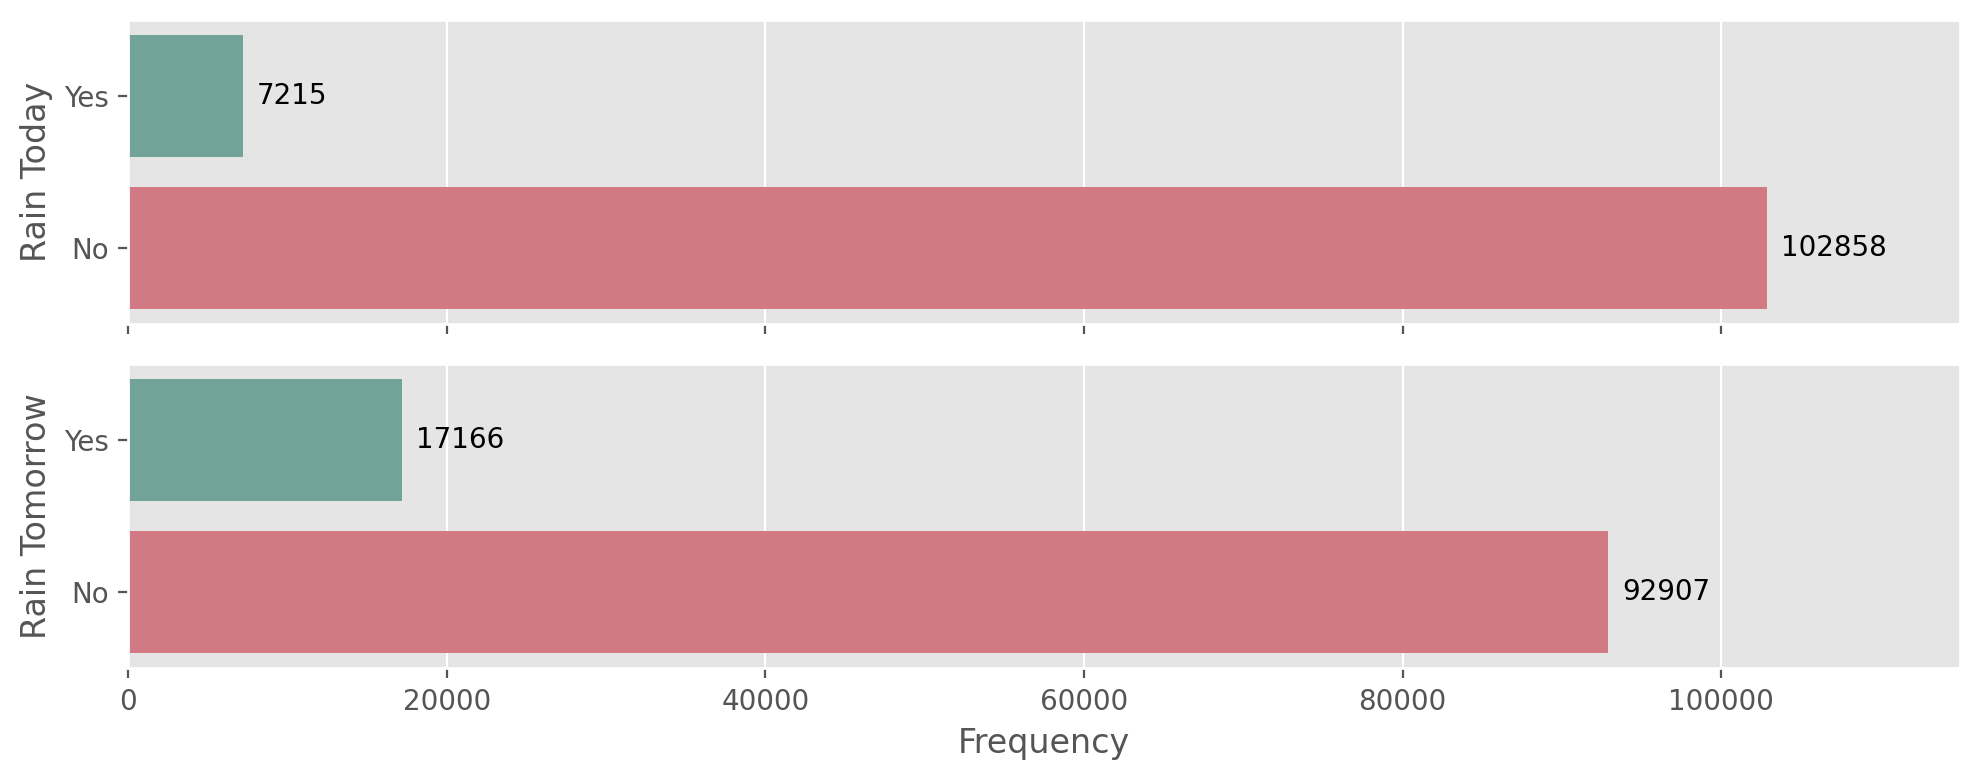

In [16]:
nrows,ncols = 2,1
fig,ax = plt.subplots(figsize=(10,4),dpi=200,nrows=nrows,ncols=ncols,sharex=True)

for i,j,k in zip(range(nrows),["raintoday","raintomorrow"],["Rain Today","Rain Tomorrow"]):
    countplot = sns.countplot(data=df,y=j,palette=["#6AAB9C","#E06C78"],order=["Yes","No"],ax=ax[i])
    for l in countplot.containers:
        countplot.bar_label(l,padding=5)
    ax[i].set_xlabel("")
    ax[i].set_xlim(0,115000)
    ax[i].set_ylabel(k)

ax[1].set_xlabel("Frequency")
plt.tight_layout()
plt.show()

Calculate the percentage of occurrence of rain on the next day based on whether if it rains today or not. As it can be seen, if it rains today, there's a greater chance that it'll rain on the next day as well.

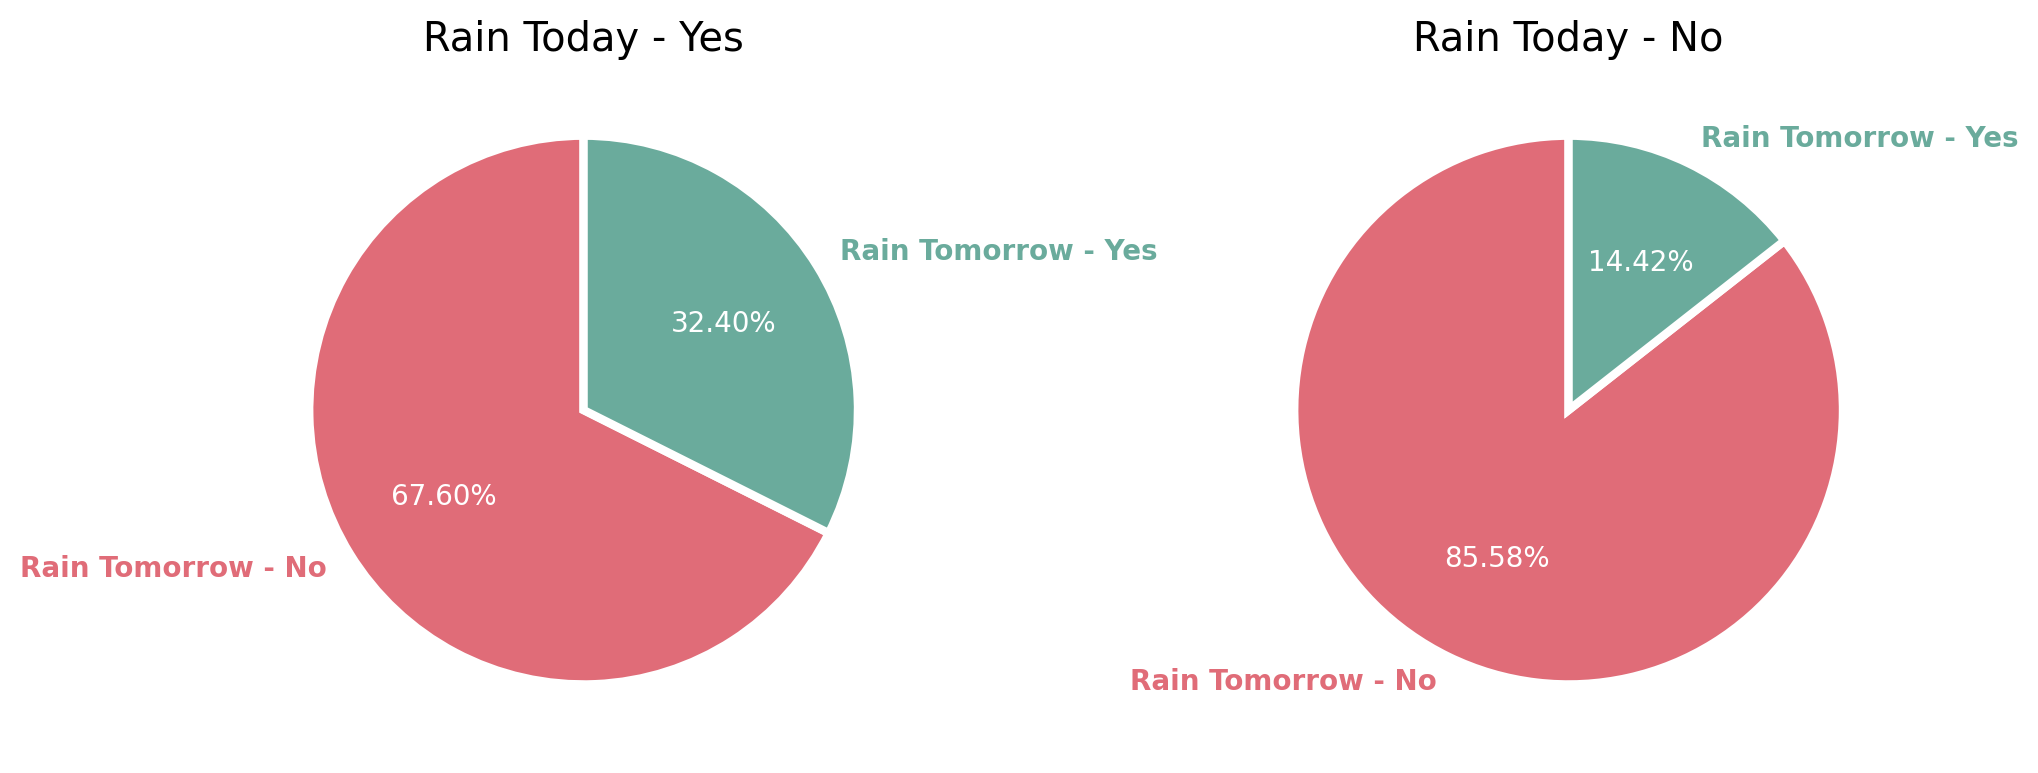

In [17]:
nrows,ncols = 1,2
fig,ax = plt.subplots(figsize=(10,4),dpi=200,nrows=nrows,ncols=ncols)

for i,j in zip(range(ncols),["Yes","No"]):
    patches,texts,pcts = ax[i].pie(
        np.ravel(df.groupby(["raintoday","raintomorrow"]).count()[["location"]].loc[j].values),
        labels=["Rain Tomorrow - No","Rain Tomorrow - Yes"],
        startangle=90,
        colors=["#E06C78","#6AAB9C"],
        autopct="%.2f%%",
        wedgeprops={"linewidth":3.0,"edgecolor":"white"},
    )
    for k,patch in enumerate(patches):
        texts[k].set_color(patch.get_facecolor())

    plt.setp(pcts,color="white")
    plt.setp(texts,fontweight=600)

    ax[i].set_title(f"Rain Today - {j}")
    
plt.tight_layout()
plt.show()

Calculate each location's average rainfall. As it can be seen, Melbourne (highlighted in blue) has the highest rainfall of 0.8+.

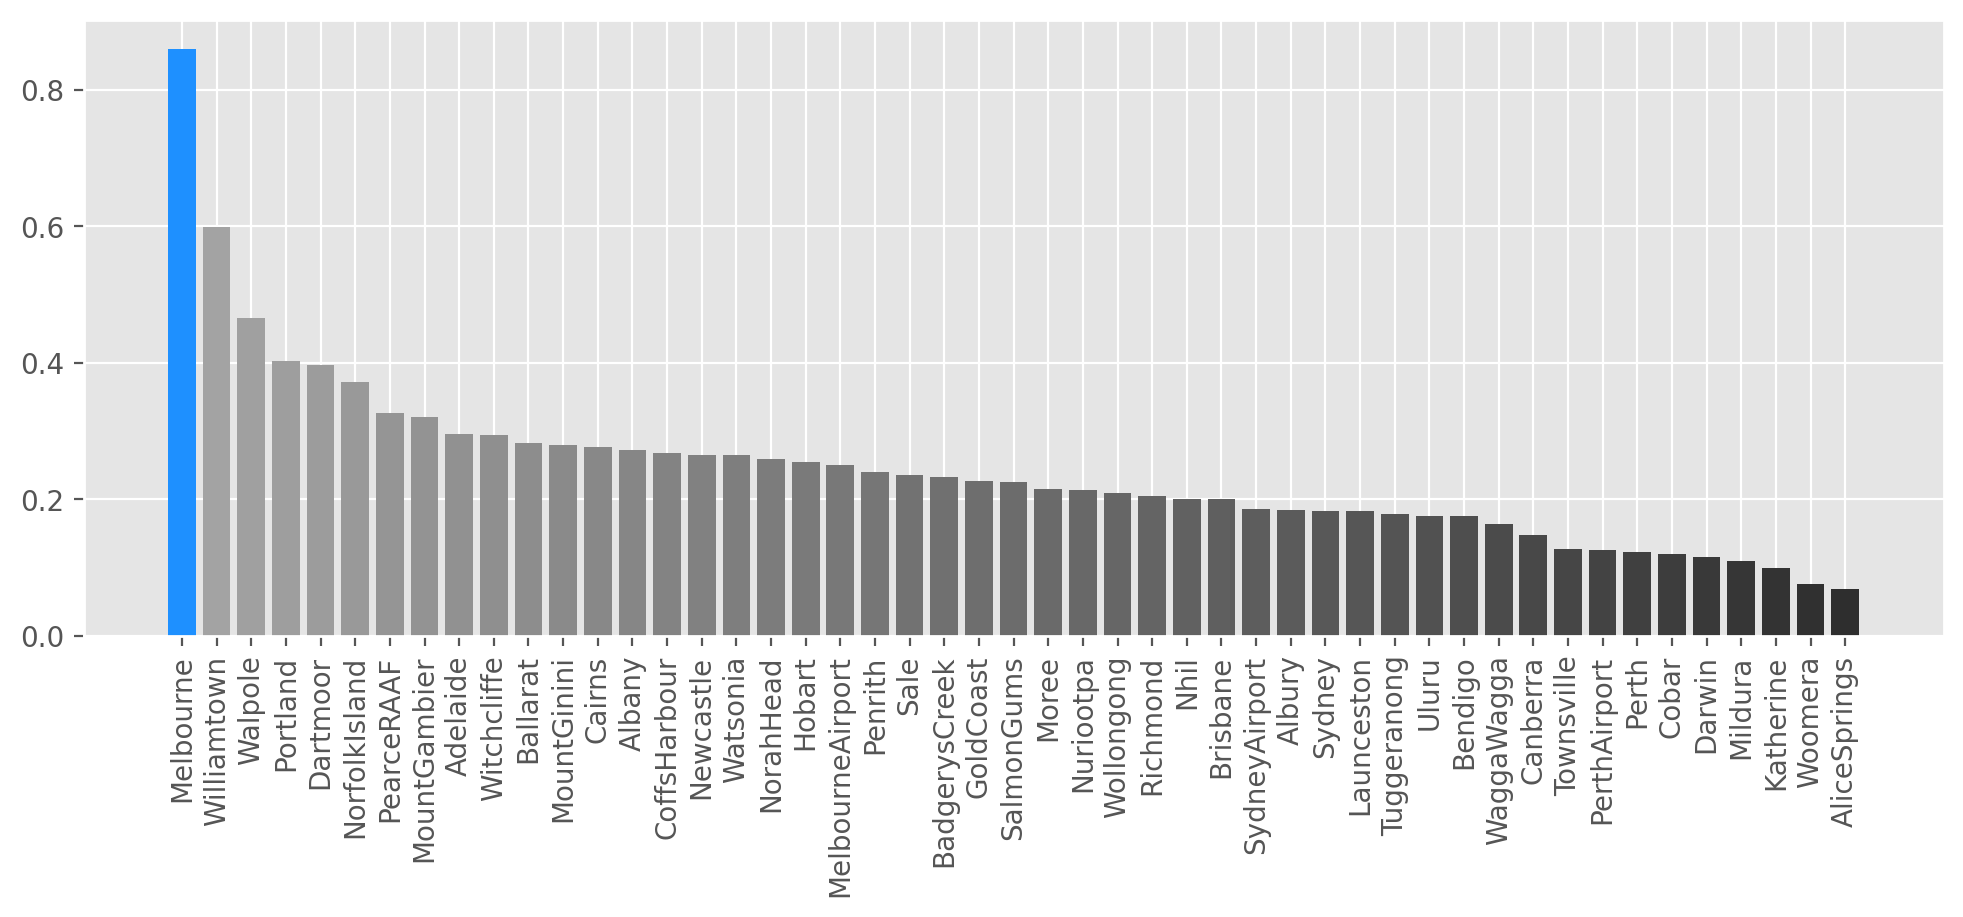

In [18]:
plt.figure(figsize=(12,4),dpi=200)

plt.bar(
    df.groupby("location").mean()[["rainfall"]].sort_values("rainfall",ascending=False).index,
    np.ravel(df.groupby("location").mean()[["rainfall"]].sort_values("rainfall",ascending=False).values),
    color=["dodgerblue"] + list(plt.get_cmap("Greys")(np.linspace(0.45,0.85,df["location"].nunique())))[1:]
)

plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

Define features (X) and target (y). We'll use *get_dummies()* to convert categorical features into dummy or indicator features.

In [19]:
X = pd.get_dummies(df.drop("raintomorrow",axis=1),drop_first=True)
y = df["raintomorrow"]

Split the dataframe into training and testing sets with a ratio of 70:30.

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

print(f"Training dataset\t: {len(X_train)} ({round(len(X_train) / len(X) * 100)}%)")
print(f"Testing dataset\t\t: {len(X_test)} ({round(len(X_test) / len(X) * 100)}%)")

Training dataset	: 77051 (70%)
Testing dataset		: 33022 (30%)


Due to all featues have different scales, we'll standardize them with *StandardScaler()*.

In [21]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

# Models Definition & Training

Create a logistic regression model and train it with the training dataset. In this case, the parameter *class_weight = balanced* is used to deal with class imbalance by giving different weights to both the majority and minority classes.

In [22]:
log_model = LogisticRegression(class_weight="balanced",random_state=42,max_iter=5000)
log_model.fit(scaled_X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

Use the logistic regression model to predict *raintomorrow* and calculate each class probability.

In [23]:
log_pred = log_model.predict(scaled_X_test)
log_prob = log_model.predict_proba(scaled_X_test)

Show the prediction result from the logistic regression model.

In [24]:
pd.DataFrame({
    "probability_yes_raintomorrow":log_prob[:,1] * 100,
    "probability_no_raintomorrow":log_prob[:,0] * 100,
    "prediction_raintomorrow":log_pred,
    "actual_raintomorrow":y_test,
    "accuracy":[True if i == j else False for i,j in zip(y_test,log_pred)]
}).reset_index(drop=True)

,probability_yes_raintomorrow,probability_no_raintomorrow,prediction_raintomorrow,actual_raintomorrow,accuracy
0,22.268972,77.731028,No,No,True
1,13.020794,86.979206,No,No,True
2,74.646646,25.353354,Yes,No,False
3,33.777403,66.222597,No,No,True
4,79.091436,20.908564,Yes,No,False
...,...,...,...,...,...
33017,53.638194,46.361806,Yes,No,False
33018,4.182378,95.817622,No,No,True
33019,7.979958,92.020042,No,No,True
33020,17.877918,82.122082,No,No,True


Create an SVM model and train it with the training dataset. The parameter *class_weight = balanced* is used as well.

In [25]:
svm_model = SVC(class_weight="balanced",random_state=42)
svm_model.fit(scaled_X_train,y_train)

SVC(class_weight='balanced', random_state=42)

Use the SVM model to predict *raintomorrow*. Unfortunately, according to various sources, *predict()* and *predict_proba()* in SVM might give inconsistent results. Also, *predict_proba()* only works if the parameter *probability = True* is used, however, it'll increase the time for training the model significantly.

In [26]:
svm_pred = svm_model.predict(scaled_X_test)

Show the prediction result from the SVM model.

In [27]:
pd.DataFrame({
    "prediction_raintomorrow":svm_pred,
    "actual_raintomorrow":y_test,
    "accuracy":[True if i == j else False for i,j in zip(y_test,svm_pred)]
}).reset_index(drop=True)

,prediction_raintomorrow,actual_raintomorrow,accuracy
0,No,No,True
1,No,No,True
2,Yes,No,False
3,No,No,True
4,No,No,True
...,...,...,...
33017,Yes,No,False
33018,No,No,True
33019,No,No,True
33020,No,No,True


# Models Evaluation

Create a function to evaluate the models.

In [28]:
def evaluation(y_test,y_pred):
    print(classification_report(y_test,y_pred))

    true_yes = confusion_matrix(y_test,y_pred)[1,1]
    false_yes = confusion_matrix(y_test,y_pred)[1,0]
    true_no = confusion_matrix(y_test,y_pred)[0,0]
    false_no = confusion_matrix(y_test,y_pred)[0,1]

    print(f"True\x1B[3m Yes\x1B[0m\t: {true_yes}\t({round(true_yes / (true_yes + false_yes) * 100,2)}%)")
    print(f"False\x1B[3m Yes\x1B[0m\t: {false_yes}\t({round(false_yes / (true_yes + false_yes) * 100,2)}%)")
    print(f"True\x1B[3m No\x1B[0m\t\t: {true_no}\t({round(true_no / (true_no + false_no) * 100,2)}%)")
    print(f"False\x1B[3m No\x1B[0m\t: {false_no}\t({round(false_no / (true_no + false_no) * 100,2)}%)")

    plt.figure(dpi=100)
    ConfusionMatrixDisplay.from_predictions(y_test,y_pred,ax=plt.gca())
    plt.grid(False)
    plt.show()

Evaluate the logistic regression model.

              precision    recall  f1-score   support

          No       0.94      0.77      0.84     27893
         Yes       0.37      0.74      0.49      5129

    accuracy                           0.76     33022
   macro avg       0.65      0.75      0.67     33022
weighted avg       0.85      0.76      0.79     33022

True Yes	: 3788	(73.85%)
False Yes	: 1341	(26.15%)
True No		: 21341	(76.51%)
False No	: 6552	(23.49%)


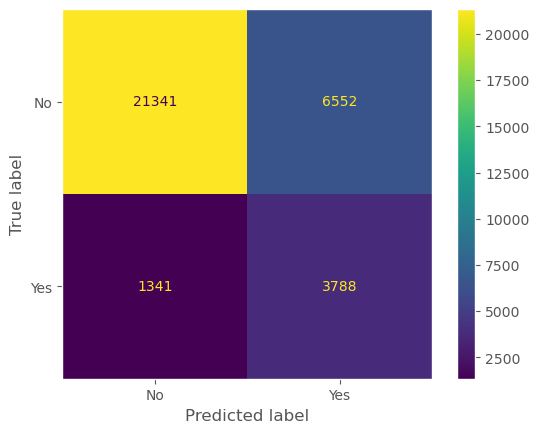

In [29]:
evaluation(y_test,log_pred)

Evaluate the SVM model.

              precision    recall  f1-score   support

          No       0.94      0.81      0.87     27893
         Yes       0.41      0.74      0.53      5129

    accuracy                           0.80     33022
   macro avg       0.68      0.77      0.70     33022
weighted avg       0.86      0.80      0.82     33022

True Yes	: 3783	(73.76%)
False Yes	: 1346	(26.24%)
True No		: 22522	(80.74%)
False No	: 5371	(19.26%)


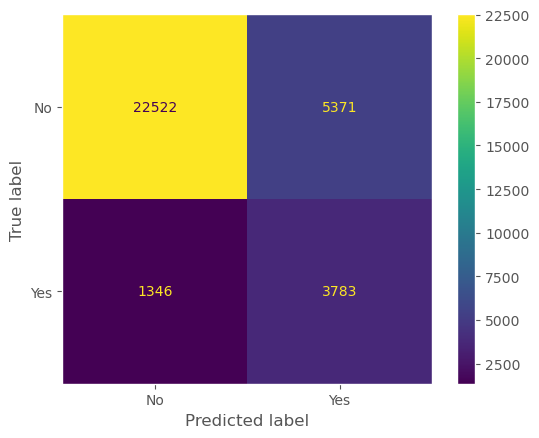

In [30]:
evaluation(y_test,svm_pred)

After each model has been evaluated, it's time to compare the results. Let's check the percentages of correct and incorrect predictions of both models.

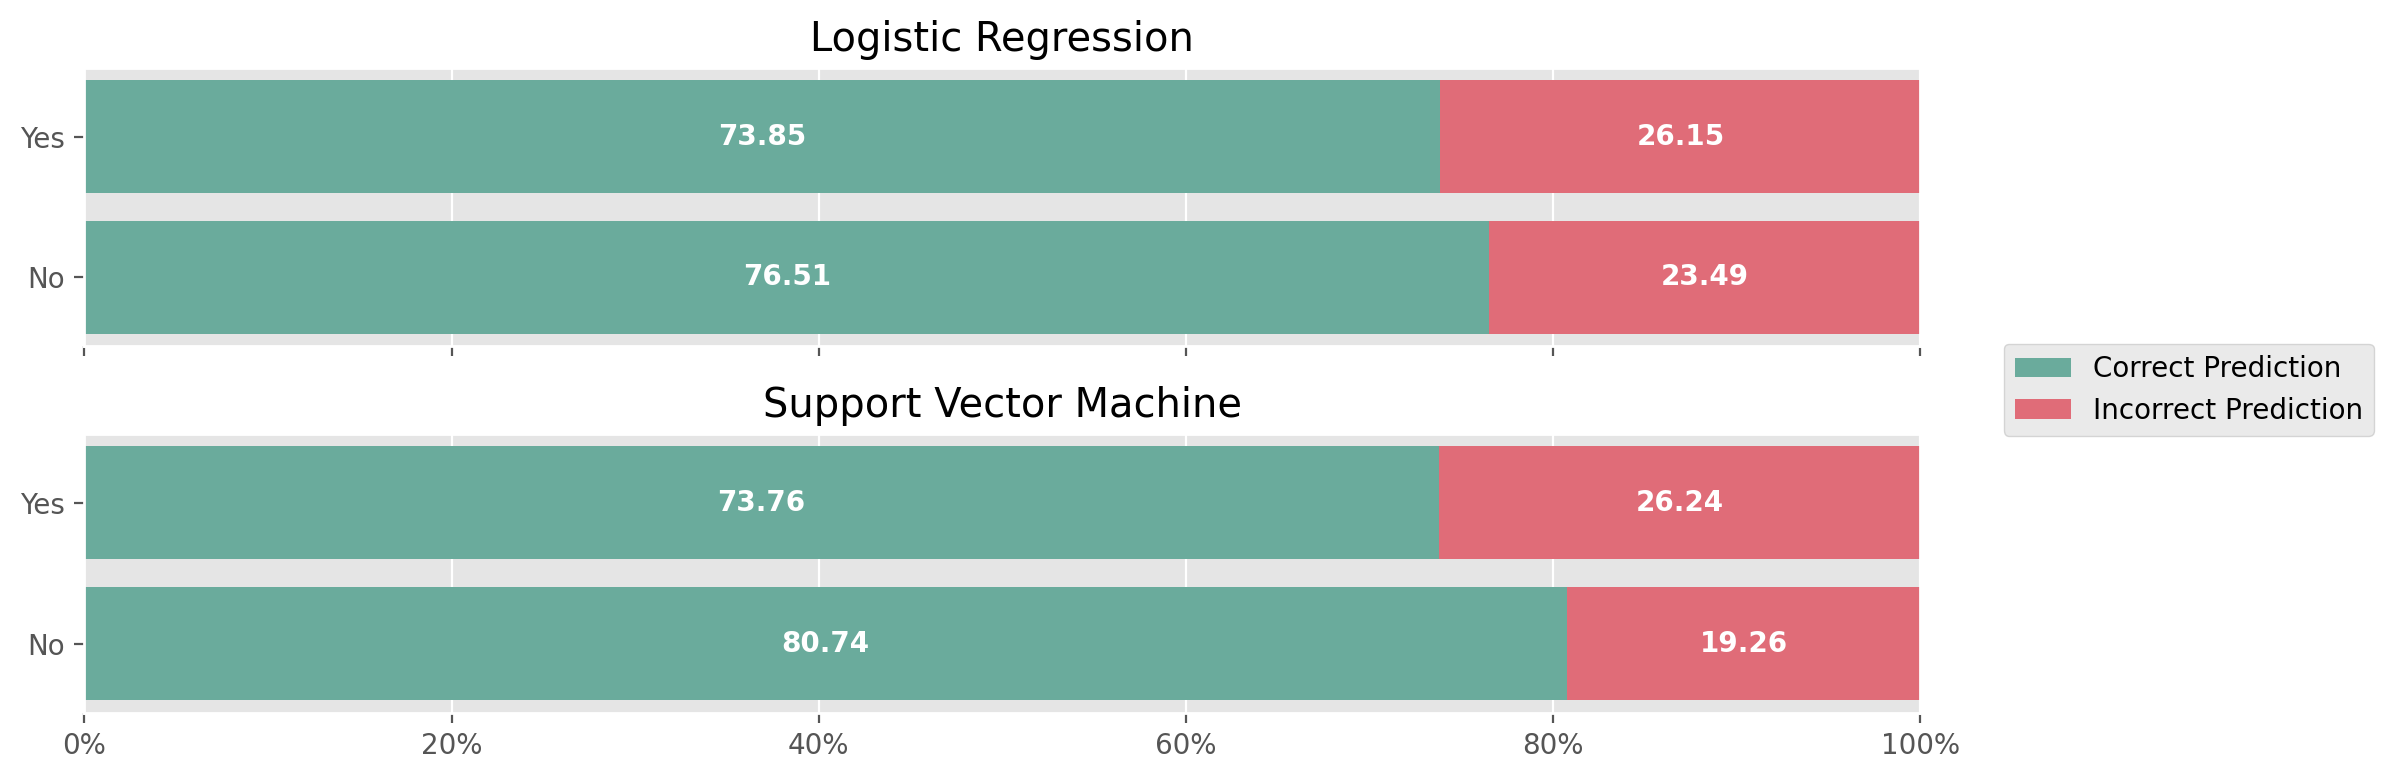

In [31]:
nrows,ncols = 2,1
fig,ax = plt.subplots(figsize=(10,4),dpi=200,nrows=nrows,ncols=ncols,sharex=True)

for i,j,k in zip(range(nrows),[log_pred,svm_pred],["Logistic Regression","Support Vector Machine"]):
    true_yes = confusion_matrix(y_test,j)[1,1]
    false_yes = confusion_matrix(y_test,j)[1,0]
    true_no = confusion_matrix(y_test,j)[0,0]
    false_no = confusion_matrix(y_test,j)[0,1]

    ax[i].barh("No",true_no / (true_no + false_no) * 100,color="#6AAB9C",label="Correct Prediction")
    ax[i].barh("No",false_no / (true_no + false_no) * 100,left=true_no / (true_no + false_no) * 100,color="#E06C78",label="Incorrect Prediction")
    ax[i].barh("Yes",true_yes / (true_yes + false_yes) * 100,color="#6AAB9C")
    ax[i].barh("Yes",false_yes / (true_yes + false_yes) * 100,left=true_yes / (true_yes + false_yes) * 100,color="#E06C78")

    ax[i].set_title(k)
    ax[i].set_xlim(xmax=100)

    for container in ax[i].containers:
        ax[i].bar_label(container,fmt="%.2f",label_type="center",color="white",fontweight="bold")

ax[i].xaxis.set_major_formatter(tick.FuncFormatter(lambda x,_: f"{round(x)}%"))
handles,labels = ax[i].get_legend_handles_labels()
fig.legend(handles,labels,bbox_to_anchor=(1,0.5),loc="center left")

plt.tight_layout()
plt.show()

Compare both models' performance scores. For *precision_score()*, *recall_score()*, and *f1_score()*, the parameter *average = weighted* is used to account for class imbalance.

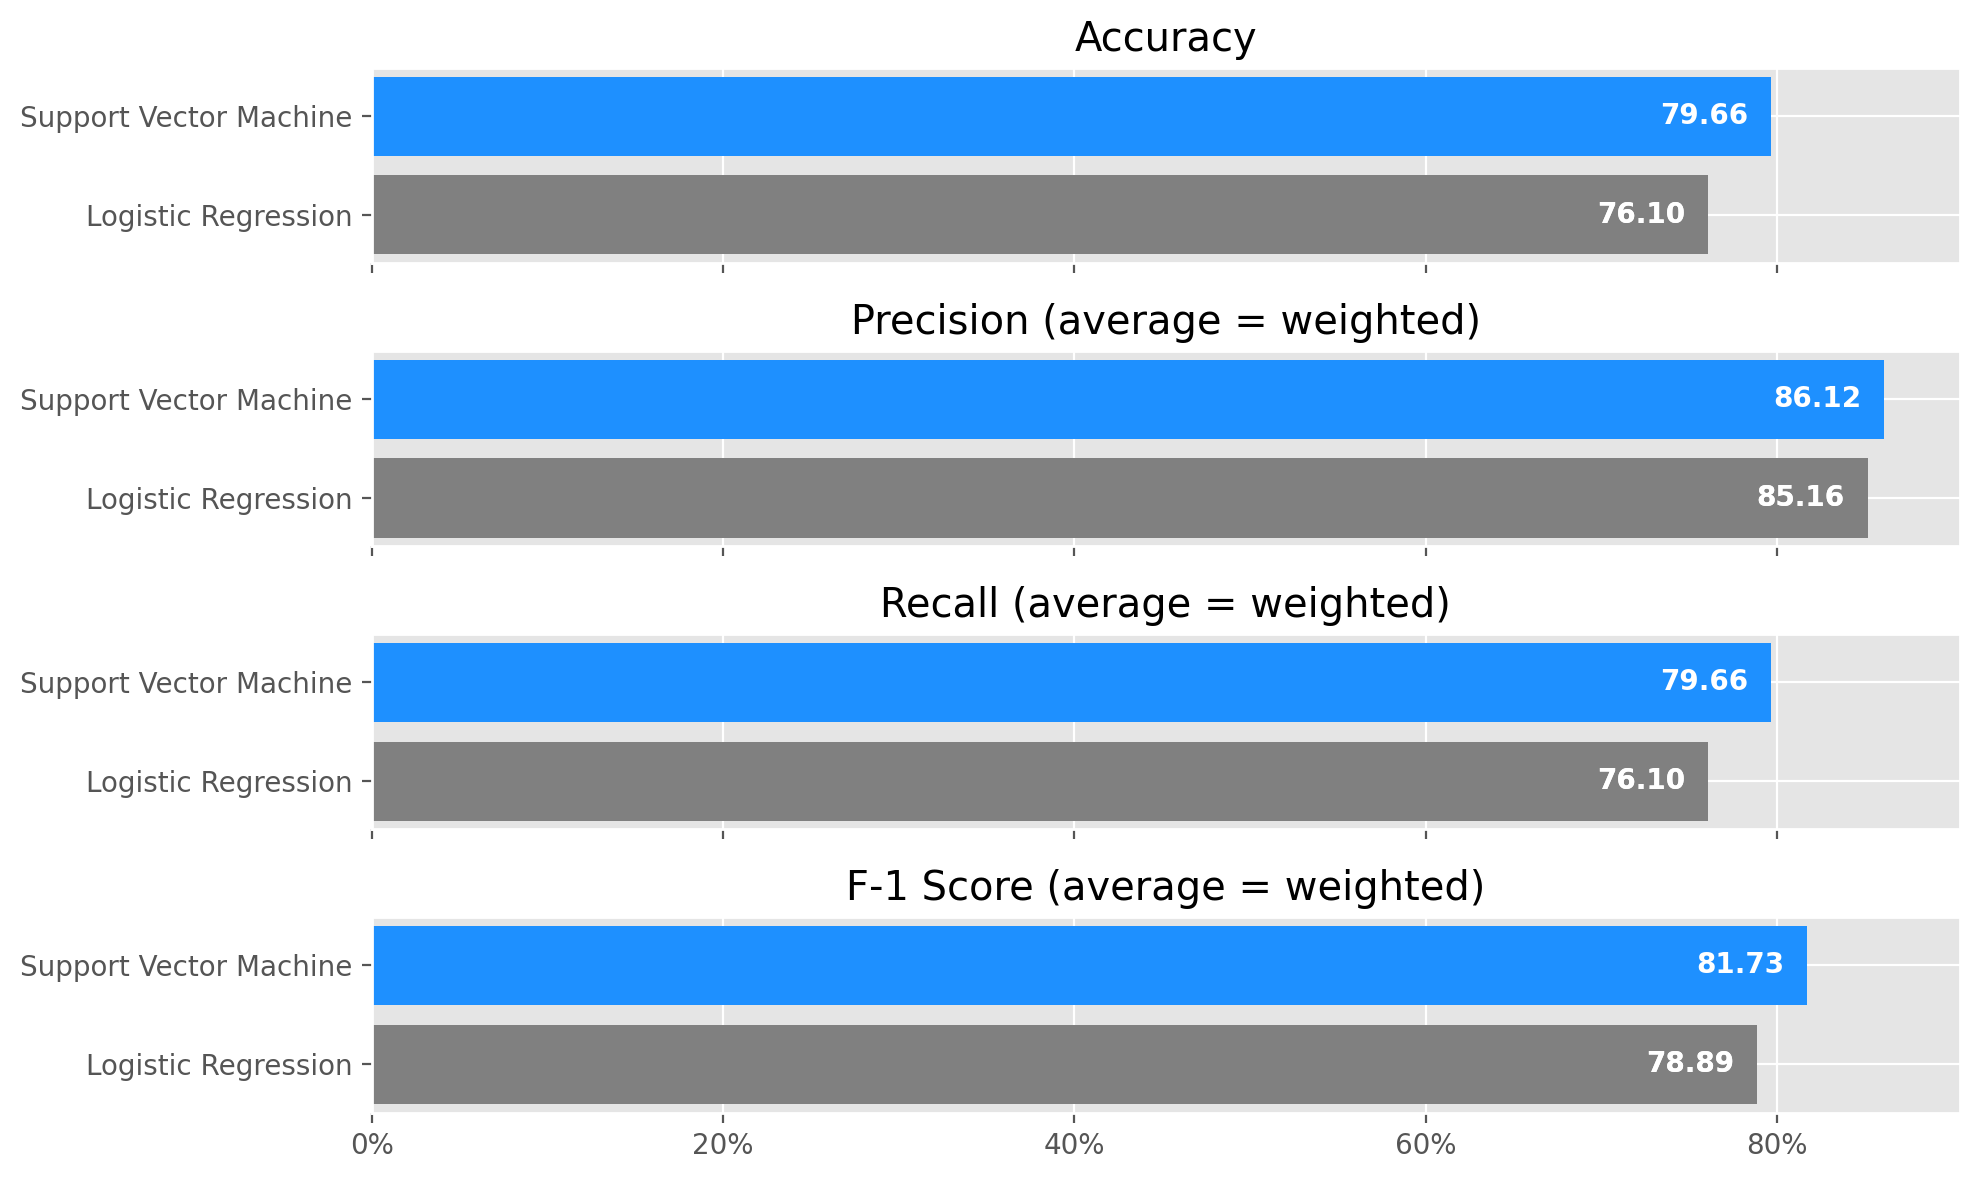

In [32]:
nrows,ncols = 4,1
fig,ax = plt.subplots(figsize=(10,6),dpi=200,nrows=nrows,ncols=ncols,sharex=True)

for i in range(nrows):
    for j,k,l in zip(
        [log_pred,svm_pred],
        ["Logistic Regression","Support Vector Machine"],
        ["grey","dodgerblue"]
    ):
        if i == 0:
            metric = accuracy_score(y_test,j) * 100
            title = "Accuracy"
        elif i == 1:
            metric = precision_score(y_test,j,average="weighted") * 100
            title = "Precision (average = weighted)"
        elif i == 2:
            metric = recall_score(y_test,j,average="weighted") * 100
            title = "Recall (average = weighted)"
        else:
            metric = f1_score(y_test,j,average="weighted") * 100
            title = "F-1 Score (average = weighted)"

        ax[i].barh(k,metric,color=l)
        ax[i].set_title(title)

        for container in ax[i].containers:
            ax[i].bar_label(container,fmt="%.2f",padding=-40,color="white",fontweight="bold")

ax[i].xaxis.set_major_formatter(tick.FuncFormatter(lambda x,_: f"{round(x)}%"))

plt.tight_layout()
plt.show()

# Final Models

Create the final logistic regression model by training it with the whole dataset. In addition, this also shows the model equation.

In [33]:
final_log_model = LogisticRegression(class_weight="balanced",max_iter=5000)
final_log_model.fit(X,y)

e,x = sp.Symbol("e"),sp.Symbol("(x)")
x_symbols = [sp.Symbol(f"({i})") for i in X.columns]

sums = np.round(final_log_model.intercept_[0],6)
for i in range(len(X.columns)):
    sums += x_symbols[i] * np.round(final_log_model.coef_[0][i],6)

sp.Eq(sp.pi*x,e**sums / (1 + e**sums))

Eq(pi*(x), e**(0.067556*(humidity3pm) + 0.001347*(humidity9am) - 0.199219*(location_Albany) + 0.679997*(location_Albury) + 0.195698*(location_AliceSprings) + 0.295301*(location_BadgerysCreek) - 0.304385*(location_Ballarat) + 0.451771*(location_Bendigo) + 0.59847*(location_Brisbane) - 0.190286*(location_Cairns) + 0.430246*(location_Canberra) + 0.419299*(location_Cobar) - 0.063284*(location_CoffsHarbour) + 0.058256*(location_Dartmoor) - 0.993706*(location_Darwin) - 0.726721*(location_GoldCoast) - 0.154712*(location_Hobart) - 0.503203*(location_Katherine) - 0.158783*(location_Launceston) - 0.253129*(location_Melbourne) - 0.057697*(location_MelbourneAirport) + 0.270942*(location_Mildura) - 0.009589*(location_Moree) + 0.104625*(location_MountGambier) - 0.585252*(location_MountGinini) + 0.045021*(location_Newcastle) - 0.123366*(location_Nhil) - 0.924837*(location_NorahHead) - 0.41617*(location_NorfolkIsland) + 0.249478*(location_Nuriootpa) + 0.113881*(location_PearceRAAF) + 0.540532*(locatio

Repeat the step above for SVM.

In [34]:
final_svm_model = SVC(class_weight="balanced")
final_svm_model.fit(X,y)

SVC(class_weight='balanced')

Create a function for prediction.

In [35]:
def predict(model,mintemp,maxtemp,rainfall,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,temp3pm,location,windgustdir,winddir9am,winddir3pm,raintoday):
    inputs = pd.DataFrame(columns=X.columns)
    location_code = [0 for i in inputs.columns[pd.Series(inputs.columns).str.startswith("location")]]
    if location != "Adelaide":
        n = 0
        for i in inputs.columns[pd.Series(inputs.columns).str.startswith("location")]:
            if location in i:
                location_code[n] = 1
                break
            n += 1 

    windgustdir_code = [0 for i in inputs.columns[pd.Series(inputs.columns).str.startswith("windgustdir")]]
    if windgustdir != "E":
        n = 0
        for i in inputs.columns[pd.Series(inputs.columns).str.startswith("windgustdir")]:
            if windgustdir in i:
                windgustdir_code[n] = 1
                break
            n += 1 

    winddir9am_code = [0 for i in inputs.columns[pd.Series(inputs.columns).str.startswith("winddir9am")]]
    if winddir9am != "E":
        n = 0
        for i in inputs.columns[pd.Series(inputs.columns).str.startswith("winddir9am")]:
            if winddir9am in i:
                winddir9am_code[n] = 1
                break
            n += 1 

    winddir3pm_code = [0 for i in inputs.columns[pd.Series(inputs.columns).str.startswith("winddir3pm")]]
    if winddir3pm != "E":
        n = 0
        for i in inputs.columns[pd.Series(inputs.columns).str.startswith("winddir3pm")]:
            if winddir3pm in i:
                winddir3pm_code[n] = 1
                break
            n += 1 

    if raintoday == "Yes":
        raintoday_code = [1]
    elif raintoday == "No":
        raintoday_code = [0]

    inputs = pd.DataFrame(
        data=[[mintemp,maxtemp,rainfall,windgustspeed,humidity9am,humidity3pm,pressure9am,pressure3pm,temp3pm] + location_code + windgustdir_code + winddir9am_code + winddir3pm_code + raintoday_code],
        columns=X.columns
    )

    pred= model.predict(inputs)[0]

    if pred == "Yes":
        return f"It will be raining tomorrow"

    elif pred == "No":
        return f"It won't be raining tomorrow"

Implement the final models by inputting new data.

In [36]:
for i,j in zip([final_log_model,final_svm_model],["Logistic Regression","Support Vector Machine"]):
    print(f'{j}\t: {predict(i,10,20,0.25,35,65,50,1015,1015,20,"Adelaide","E","E","E","No")}')

Logistic Regression	: It won't be raining tomorrow
Support Vector Machine	: It won't be raining tomorrow


Save all the final models for future use.

In [37]:
model = [final_log_model,final_svm_model]
file_name = ["logistic_regression_model","support_vector_machine_model"]
extension = "json"

for i,j in zip(model,file_name):
    with open(f"{j}.{extension}","wb") as files:
        dump(i,files)
    print(f"{j}.{extension} has been downloaded")

logistic_regression_model.json has been downloaded
support_vector_machine_model.json has been downloaded


# Conclusion

Based on the analysis above, it can be seen that both logistic regression and SVM models handled the class imbalance problem well, which was proven by the high percentages of correct predictions (true *Yes* and true *No*). Furthermore, both models had high scores of ±80% on multiple metrics such as accuracy, precision, recall, and f-1 score. Since the SVM model performed slightly better than the logistic regression model, it's recommended to use the former one. Hence, it can be concluded that the SVM model is the best model to predict rain in Australia and can be used for future use. 